# BIPI-Net: Physics-Informed Integral Network for Laplace Equation
Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.

---

## Problem setup

### Laplace equation 
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$

$${x}:=(x_1, x_2)\, \in \Omega \subseteq \mathbb{R}^2$$

For sake of simplicity, we choose $\Omega$ to be a circle with radius $r=1.5$ around the origin.

### Single and double layer potential
For a point $x\in\Omega$ inside the domain we have 
$$u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y) \; dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y) \; dS_y \right).$$
But for a boundary point $x\in\Gamma:=\partial\Omega$ we have get a jump
$$
u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y)\; dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y)\; dS_y \right) +
\frac{1}{2}g(x).
$$



### Uniformal sampled datapoints based on Dirichlet boundary conditions
Let ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ be the measurements constructed by a finite difference solution of the Laplace equation based on Dirichlet boundary conditions.

## Initial settings

In [1]:
# load packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  
from matplotlib.font_manager import FontProperties
import pandas as pd
import os

In [2]:
# plot specifications
matplotlib.rcParams['text.usetex'] = True
# font properties for axis
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115)  
# font properties for 3d plot axis
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)  

## Dataset setup

In [3]:
# read data from CSV file
def read_data(csv_file):
    """
    read csv file and store data in x_data, u_data
    
    Args:
    - csv_file
    
    Returns:
    - x_data: tensor of shape (N,2) containing N positions x=(x1,x2)
    - u_data: tensor of shape (N,1) containing u values to corresponding x
    
    """

    # read data from CSV file
    data_pd = pd.read_csv(csv_file)
    data_tensor = torch.tensor(data_pd.values, dtype=torch.float32)  # x1, x2, u
    x_data = data_tensor[:, 0:2] 
    u_data = data_tensor[:, 2].view(-1, 1)  
    
    return x_data, u_data


x_data, u_data = read_data('dataset_laplace.csv')
x_data.shape

torch.Size([90, 2])

In [4]:
x_new = []
u_new = []
x_remove = []
x_data = np.array(x_data)
u_data = np.array(u_data)
limit = 0.8

for k in range(u_data.shape[0]):
    if (-limit < x_data[k,0]) & (x_data[k,0]<limit) & (-limit < x_data[k,1]) & (x_data[k,1]<limit):
        x_remove.append(x_data[k,:])
    else:
        x_new.append(x_data[k,:])
        u_new.append(u_data[k,:])

        
x_data = torch.tensor(np.array(x_new))
u_data = torch.tensor(np.array(u_new))
x_data.shape

torch.Size([30, 2])

## Finite difference solution

In [5]:
# read data from CSV file
x_num = pd.read_csv('X_mesh.csv')
x_num = torch.tensor(x_num.values, dtype=torch.float32)  # x1, x2

# read data from CSV file
u_num = pd.read_csv('u_num.csv')
u_num = torch.tensor(u_num.values, dtype=torch.float32)  # u

N = u_num.shape
N

torch.Size([10201, 1])

## Collocation and integration points

In [6]:
n_coll_int_points = 1_000
radius = 1.5
middle = torch.tensor((0,0)).view(1,2)

In [7]:
# randomly sample colloction and integration points on the circle
def collocation_integration_points(n, radius, middle):
    # add random shift
    angle = (2 * np.pi * torch.rand(1)).item()

    # define angles
    n = n + 1
    theta = np.linspace(0, 2 * np.pi, n) + angle
    theta = theta[1::]  # to remove one double angle at 0 and 2*pi
    # split theta into two sets
    theta_coll = theta[::2]  # select every second point
    theta_int = theta[1::2]  # select every other points

    # define collocation points
    x1_coll = middle[:, 0] + radius * np.cos(theta_coll).reshape(int(n / 2), 1)
    x2_coll = middle[:, 1] + radius * np.sin(theta_coll).reshape(int(n / 2), 1)
    x_collocation = np.concatenate((x1_coll, x2_coll), axis=1)
    x_collocation = torch.tensor(x_collocation, dtype=torch.float32).requires_grad_(True)

    # define integration points
    x1_int = middle[:, 0] + radius * np.cos(theta_int).reshape(int(n / 2), 1)
    x2_int = middle[:, 1] + radius * np.sin(theta_int).reshape(int(n / 2), 1)
    x_integration = np.concatenate((x1_int, x2_int), axis=1)
    x_integration = torch.tensor(x_integration, dtype=torch.float32).requires_grad_(True)

    return x_collocation, x_integration 

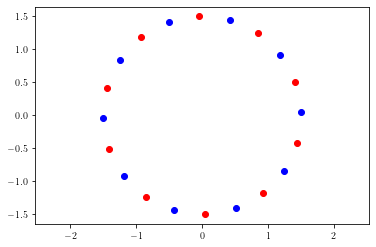

In [8]:
# visualisation of the collocation and integration points
n = 20
x_collocation, x_integration = collocation_integration_points(n, radius, middle)
x_coll_np = x_collocation.detach().numpy()
x_int_np = x_integration.detach().numpy()

# plot collocation and integration points
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], color='red', label='Collocation Points')
plt.scatter(x_int_np[:, 0], x_int_np[:, 1], color='blue', label='Integration Points')
plt.axis('equal')
plt.show()

## Physics initialisation

In [9]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x, radius, middle):
    """
    computes outer normal vector normals that is orthogonal to surface of Omega
    
    Args:
    - x: tensor of shape (N,2) containing N positions (x1, x2) on boundary of Omega
    - radius
    - middle
    
    Returns:
    - normals: tensor of shape (N,2) containing the outer normal vector on boundary of Omega at each position in x
    
    """

    N = x.shape[0]  # number of points
    xc = x - middle  # cetered
    normals = xc / radius

    return normals


# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):
    """
    computes the fundamental solution of the Laplace equation in 2D at N positions in  
    two points x and y in R^2, given by
    Phi_0(x, y) = -1/(2π) * log(||x - y||)
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - Phi_0: torch.tensor of shape (N,1), value of Laplace fundamental solution over x and y
    
    """

    distance = torch.norm(x - y, p=2, dim=1).view(-1, 1)

    Phi_0 = -1 / (2 * np.pi) * torch.log(distance)
    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):
    """
    computes the gradient *with respect to x* of the Laplace fundamental solution in 2D at N positions x and y, 
    given by ∇y Phi_0(x,y) = - 1/(2π) * (x - y)/||x - y||²
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - grad_Phi_0: torch.tensor of shape (N,2), gradient of Laplace fundamental solution over x and y
    
    """
    distance = torch.norm(x - y, p=2, dim=1).view(-1, 1)
    
    grad_Phi_0 = (1 / (2 * np.pi)) * ((x - y) / distance ** 2)
    
    return grad_Phi_0

## Network setup

In [10]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        """
        class implementation of a fully-connected neural network with PyTorch given by Args
        
        Args:
        - N_input: integer, number of input dimension, here N_input = 2 given by x=(x1, x2)
        - N_output: integer, number of output dimession, here N_output = 1 given by u(x)
        - N_hidden: integer, depth of one hidden layer
        - N_layers: integer, number of hidden layers in the network
        
        Methods:
        - forward: forward pass of neural network
        
        """
        super().__init__()  
        activation = nn.ELU
                
        # input / start layer
        self.fc_start = nn.Sequential(*[ 
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ]) 
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)
        
        
    #------------------------------    
    # forward pass through network
    def forward(self, x):
        """
        forward pass through network building blocks given in this class above
        
        Args:
        - x: tensor of shape (N, 2) containing N positions (x1, x2)

        Returns:
        - u: tensor of shape (N,1) containing the network solution u at position x
        
        """ 
        # forward network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x) # hidden layer(s)
        u = self.fc_end(x)    # output layer 
        
        return u
        
        
    #------------------------------    
    # calculating the potential integrals
    def resample(self):
        # sampling new collocation and integration points
        self.x_coll, self.x_int = collocation_integration_points(n_coll_int_points, radius, middle)
        # calculating the potentials
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')
        self.vmapped_potential_boundary = torch.vmap(self.calc_potentials_boundary, randomness='same')
        
        
    #------------------------------    
    # calculating the single and double layer potentials for x being an inside Omega point
    def calc_potentials_inside(self, x):
        """
        Inner domain points
        
        """
        y = self.x_int
        normal_y = outer_normal(y, radius, middle)
        g_y = self(y) # boundary density, performs forward pass through  neural network with the input y 
        
        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y)
        return double_layer.squeeze(), single_layer.squeeze()

    
    #------------------------------
    # calculating the single and double layer potentials for x being a collocation point on the boundary of Omega
    def calc_potentials_boundary(self, x):
        """
        for collocation points on the boundary
        
        """
        y = self.x_int
        g_y = self(y)
        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        normal_y = outer_normal(y, radius, middle)
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y) - 0.5 * pibi(x)
        return double_layer.squeeze(), single_layer.squeeze()
    
    
    #------------------------------
    def predict_u_inside(self, x):
        double_layer, single_layer = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_data

    
    #------------------------------
    def predict_u_boundary(self, x):
        double_layer, single_layer = self.vmapped_potential_boundary(x)
        u_int_boundary = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_boundary

In [11]:
def initialise_pibi(lr):
    
    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 512
    N_layers = 3  # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers)

    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, eps=1e-12, verbose=True)

    # loss function
    mse_loss = torch.nn.MSELoss()

    return pibi, optimiser, scheduler, mse_loss

## Train PIBI and visualise trained solution

In [12]:
def train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler, mse_loss):
    # n: number of collocation and integration points
    # store loss values
    loss_values = []

    for epoch in range(iterations):
        optimiser.zero_grad()
        
        pibi.resample()
        x_coll = pibi.x_coll

        u_int_data = pibi.predict_u_inside(x_data)
        # compute data loss
        loss_int_data = mse_loss(u_int_data, u_data)

        u_int_coll = pibi.predict_u_boundary(x_coll)
        # compute collocation loss
        loss_int_coll = mse_loss(u_int_coll, torch.zeros_like(u_int_coll))

        # backpropagate weighted joint loss, take optimiser step
        loss = lambda_physics_data * loss_int_data + lambda_physics_coll * loss_int_coll
        loss_values.append(loss.item()) 
        loss.backward()
        optimiser.step()
        scheduler.step(loss)

        
        # plot result as training progresses on test set
        if epoch % 2 == 0:
            print('epoch:', epoch, ', data:', loss_int_data.data, ', coll:', loss_int_coll.data)

            if epoch == iterations - 1:
                torch.save(pibi.state_dict(), "pibi_model.pt")

                # solve integral for plot points
                _, x_int = collocation_integration_points(n, radius, middle)
                u_pibi = pibi.predict_u_inside(x_num)
                x1 = (x_num[:, 0]).reshape((101, 101))  
                x2 = (x_num[:, 1]).reshape((101, 101))  
                u_nn = u_pibi.reshape(x1.shape) 
                u_nn = u_nn.detach()

                # evaluation plot in 3D
                fig = plt.figure(figsize=(15, 15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_nn, cmap=cm.jet, zorder=1, alpha=1)
                ax.scatter(x_data[:, 0], x_data[:, 1], u_data, c='black', marker='o', s=10 ** 2, alpha=1, zorder=2)
                surf.set_clim(vmin=-1, vmax=1)  
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                # Save the figure as a JPEG image
                plt.savefig('pibi_3d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()

                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_nn, cmap='jet', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                ax.scatter(x_data[:, 0], x_data[:, 1], c='black', marker='o', s=10 ** 2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                # Save the figure as a JPEG image 
                plt.savefig('pibi_2d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()

                # absolute error plot
                u_num_matrix = u_num.reshape(u_nn.shape)
                u_error = torch.abs(u_nn - u_num_matrix)
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet_r', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=0, vmax=1.1)
                ax.scatter(x_data[:, 0], x_data[:, 1], c='black', marker='o', s=10 ** 2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                plt.savefig('pibi_error_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                u_vec = u_error.reshape(N, 1)
                print('min', torch.min(u_vec), 'max', torch.max(u_vec), 'mean', torch.mean(u_vec))

    return loss_values, pibi

epoch: 0 , data: tensor(0.3033) , coll: tensor(0.0049)
epoch: 2 , data: tensor(0.1480) , coll: tensor(3.4507)
epoch: 4 , data: tensor(0.1297) , coll: tensor(11.5496)
epoch: 6 , data: tensor(0.1361) , coll: tensor(12.2064)
epoch: 8 , data: tensor(0.1153) , coll: tensor(11.0490)
epoch: 10 , data: tensor(0.1127) , coll: tensor(9.7793)
epoch: 12 , data: tensor(0.1037) , coll: tensor(6.7056)
epoch: 14 , data: tensor(0.1003) , coll: tensor(5.8041)
epoch: 16 , data: tensor(0.0942) , coll: tensor(7.9615)
epoch: 18 , data: tensor(0.0880) , coll: tensor(10.1031)
epoch: 20 , data: tensor(0.0804) , coll: tensor(10.1505)
epoch: 22 , data: tensor(0.0790) , coll: tensor(9.9658)
epoch: 24 , data: tensor(0.0725) , coll: tensor(10.7730)
epoch: 26 , data: tensor(0.0681) , coll: tensor(11.5916)
epoch: 28 , data: tensor(0.0652) , coll: tensor(11.0832)
epoch: 30 , data: tensor(0.0617) , coll: tensor(10.8121)
epoch: 32 , data: tensor(0.0585) , coll: tensor(13.0569)
epoch: 34 , data: tensor(0.0555) , coll: te

epoch: 284 , data: tensor(0.0310) , coll: tensor(46.2926)
epoch: 286 , data: tensor(0.0309) , coll: tensor(46.3518)
epoch: 288 , data: tensor(0.0308) , coll: tensor(46.5051)
epoch: 290 , data: tensor(0.0307) , coll: tensor(46.5932)
epoch: 292 , data: tensor(0.0306) , coll: tensor(46.7247)
epoch: 294 , data: tensor(0.0305) , coll: tensor(46.8491)
epoch: 296 , data: tensor(0.0304) , coll: tensor(46.9409)
epoch: 298 , data: tensor(0.0303) , coll: tensor(47.0740)
epoch: 300 , data: tensor(0.0302) , coll: tensor(47.1678)
epoch: 302 , data: tensor(0.0301) , coll: tensor(47.2792)
epoch: 304 , data: tensor(0.0299) , coll: tensor(47.4058)
epoch: 306 , data: tensor(0.0298) , coll: tensor(47.5045)
epoch: 308 , data: tensor(0.0297) , coll: tensor(47.6254)
epoch: 310 , data: tensor(0.0296) , coll: tensor(47.7436)
epoch: 312 , data: tensor(0.0294) , coll: tensor(47.8380)
epoch: 314 , data: tensor(0.0293) , coll: tensor(47.9457)
epoch: 316 , data: tensor(0.0292) , coll: tensor(48.0692)
epoch: 318 , d

epoch: 566 , data: tensor(0.0134) , coll: tensor(78.8011)
epoch: 568 , data: tensor(0.0133) , coll: tensor(79.2176)
epoch: 570 , data: tensor(0.0132) , coll: tensor(79.4799)
epoch: 572 , data: tensor(0.0131) , coll: tensor(79.6283)
epoch: 574 , data: tensor(0.0130) , coll: tensor(79.9735)
epoch: 576 , data: tensor(0.0129) , coll: tensor(80.1043)
epoch: 578 , data: tensor(0.0129) , coll: tensor(80.4010)
epoch: 580 , data: tensor(0.0129) , coll: tensor(80.5464)
epoch: 582 , data: tensor(0.0128) , coll: tensor(80.8531)
epoch: 584 , data: tensor(0.0128) , coll: tensor(81.0198)
epoch: 586 , data: tensor(0.0127) , coll: tensor(81.3439)
epoch: 588 , data: tensor(0.0126) , coll: tensor(81.4519)
epoch: 590 , data: tensor(0.0126) , coll: tensor(81.8594)
epoch: 592 , data: tensor(0.0125) , coll: tensor(81.8881)
epoch: 594 , data: tensor(0.0124) , coll: tensor(82.3169)
epoch: 596 , data: tensor(0.0124) , coll: tensor(82.3911)
epoch: 598 , data: tensor(0.0123) , coll: tensor(82.7655)
epoch: 600 , d

epoch: 848 , data: tensor(0.0055) , coll: tensor(124.2990)
epoch: 850 , data: tensor(0.0054) , coll: tensor(124.6833)
epoch: 852 , data: tensor(0.0054) , coll: tensor(125.0648)
epoch: 854 , data: tensor(0.0053) , coll: tensor(125.5257)
epoch: 856 , data: tensor(0.0053) , coll: tensor(125.9677)
epoch: 858 , data: tensor(0.0052) , coll: tensor(126.2957)
epoch: 860 , data: tensor(0.0052) , coll: tensor(126.6928)
epoch: 862 , data: tensor(0.0051) , coll: tensor(127.2425)
epoch: 864 , data: tensor(0.0051) , coll: tensor(127.7264)
epoch: 866 , data: tensor(0.0052) , coll: tensor(128.0432)
epoch: 868 , data: tensor(0.0055) , coll: tensor(128.4561)
epoch: 870 , data: tensor(0.0057) , coll: tensor(129.0122)
epoch: 872 , data: tensor(0.0054) , coll: tensor(129.4270)
epoch: 874 , data: tensor(0.0049) , coll: tensor(129.6890)
epoch: 876 , data: tensor(0.0051) , coll: tensor(130.0928)
epoch: 878 , data: tensor(0.0051) , coll: tensor(130.5244)
epoch: 880 , data: tensor(0.0048) , coll: tensor(130.953

epoch: 1122 , data: tensor(0.0023) , coll: tensor(161.5095)
epoch: 1124 , data: tensor(0.0023) , coll: tensor(161.7684)
epoch: 1126 , data: tensor(0.0022) , coll: tensor(161.8837)
epoch: 1128 , data: tensor(0.0022) , coll: tensor(162.2048)
epoch: 1130 , data: tensor(0.0022) , coll: tensor(162.2955)
epoch: 1132 , data: tensor(0.0022) , coll: tensor(162.6106)
epoch: 1134 , data: tensor(0.0022) , coll: tensor(162.7229)
epoch: 1136 , data: tensor(0.0022) , coll: tensor(163.0004)
epoch: 1138 , data: tensor(0.0022) , coll: tensor(163.1561)
epoch: 1140 , data: tensor(0.0022) , coll: tensor(163.3687)
epoch: 1142 , data: tensor(0.0021) , coll: tensor(163.5949)
epoch: 1144 , data: tensor(0.0021) , coll: tensor(163.7419)
epoch: 1146 , data: tensor(0.0021) , coll: tensor(164.0213)
epoch: 1148 , data: tensor(0.0021) , coll: tensor(164.1616)
epoch: 1150 , data: tensor(0.0021) , coll: tensor(164.4226)
epoch: 1152 , data: tensor(0.0021) , coll: tensor(164.6072)
epoch: 1154 , data: tensor(0.0021) , col

epoch: 1396 , data: tensor(0.0010) , coll: tensor(187.5297)
epoch: 1398 , data: tensor(0.0010) , coll: tensor(187.7100)
epoch: 1400 , data: tensor(0.0010) , coll: tensor(187.8604)
epoch: 1402 , data: tensor(0.0010) , coll: tensor(188.0396)
epoch: 1404 , data: tensor(0.0010) , coll: tensor(188.2010)
epoch: 1406 , data: tensor(0.0010) , coll: tensor(188.2609)
epoch: 1408 , data: tensor(0.0010) , coll: tensor(188.4449)
epoch: 1410 , data: tensor(0.0010) , coll: tensor(188.6944)
epoch: 1412 , data: tensor(0.0010) , coll: tensor(188.7897)
epoch: 1414 , data: tensor(0.0010) , coll: tensor(188.9205)
epoch: 1416 , data: tensor(0.0010) , coll: tensor(189.1319)
epoch: 1418 , data: tensor(0.0010) , coll: tensor(189.2868)
epoch: 1420 , data: tensor(0.0010) , coll: tensor(189.4837)
epoch: 1422 , data: tensor(0.0010) , coll: tensor(189.6153)
epoch: 1424 , data: tensor(0.0010) , coll: tensor(189.7165)
epoch: 1426 , data: tensor(0.0009) , coll: tensor(189.9021)
epoch: 1428 , data: tensor(0.0009) , col

epoch: 1668 , data: tensor(0.0006) , coll: tensor(200.8466)
epoch: 1670 , data: tensor(0.0006) , coll: tensor(200.8960)
epoch: 1672 , data: tensor(0.0006) , coll: tensor(200.9419)
epoch: 1674 , data: tensor(0.0006) , coll: tensor(201.0057)
epoch: 1676 , data: tensor(0.0006) , coll: tensor(201.0650)
epoch: 1678 , data: tensor(0.0006) , coll: tensor(201.1125)
epoch: 1680 , data: tensor(0.0006) , coll: tensor(201.1685)
epoch: 1682 , data: tensor(0.0006) , coll: tensor(201.2027)
epoch: 1684 , data: tensor(0.0006) , coll: tensor(201.2675)
epoch: 1686 , data: tensor(0.0006) , coll: tensor(201.3014)
epoch: 1688 , data: tensor(0.0006) , coll: tensor(201.3766)
epoch: 1690 , data: tensor(0.0006) , coll: tensor(201.4140)
epoch: 1692 , data: tensor(0.0006) , coll: tensor(201.4738)
epoch: 1694 , data: tensor(0.0006) , coll: tensor(201.5177)
epoch: 1696 , data: tensor(0.0006) , coll: tensor(201.5812)
epoch: 1698 , data: tensor(0.0006) , coll: tensor(201.6379)
epoch: 1700 , data: tensor(0.0006) , col

epoch: 1942 , data: tensor(0.0005) , coll: tensor(207.0645)
epoch: 1944 , data: tensor(0.0005) , coll: tensor(207.0853)
epoch: 1946 , data: tensor(0.0005) , coll: tensor(207.1374)
epoch: 1948 , data: tensor(0.0005) , coll: tensor(207.1767)
epoch: 1950 , data: tensor(0.0005) , coll: tensor(207.2064)
epoch: 1952 , data: tensor(0.0005) , coll: tensor(207.2616)
epoch: 1954 , data: tensor(0.0005) , coll: tensor(207.2790)
epoch: 1956 , data: tensor(0.0005) , coll: tensor(207.3410)
epoch: 1958 , data: tensor(0.0005) , coll: tensor(207.3663)
epoch: 1960 , data: tensor(0.0005) , coll: tensor(207.4032)
epoch: 1962 , data: tensor(0.0005) , coll: tensor(207.4481)
epoch: 1964 , data: tensor(0.0005) , coll: tensor(207.4675)
epoch: 1966 , data: tensor(0.0005) , coll: tensor(207.5328)
epoch: 1968 , data: tensor(0.0005) , coll: tensor(207.5265)
epoch: 1970 , data: tensor(0.0004) , coll: tensor(207.5983)
epoch: 1972 , data: tensor(0.0004) , coll: tensor(207.6186)
epoch: 1974 , data: tensor(0.0004) , col

epoch: 2216 , data: tensor(0.0004) , coll: tensor(211.2862)
epoch: 2218 , data: tensor(0.0004) , coll: tensor(211.3225)
epoch: 2220 , data: tensor(0.0004) , coll: tensor(211.3344)
epoch: 2222 , data: tensor(0.0004) , coll: tensor(211.3499)
epoch: 2224 , data: tensor(0.0004) , coll: tensor(211.3941)
epoch: 2226 , data: tensor(0.0004) , coll: tensor(211.3936)
epoch: 2228 , data: tensor(0.0004) , coll: tensor(211.4320)
epoch: 2230 , data: tensor(0.0004) , coll: tensor(211.4622)
epoch: 2232 , data: tensor(0.0004) , coll: tensor(211.4587)
epoch: 2234 , data: tensor(0.0004) , coll: tensor(211.5184)
epoch: 2236 , data: tensor(0.0004) , coll: tensor(211.5159)
epoch: 2238 , data: tensor(0.0004) , coll: tensor(211.5591)
epoch: 2240 , data: tensor(0.0004) , coll: tensor(211.5817)
epoch: 2242 , data: tensor(0.0004) , coll: tensor(211.5893)
epoch: 2244 , data: tensor(0.0004) , coll: tensor(211.6371)
epoch: 2246 , data: tensor(0.0004) , coll: tensor(211.6373)
epoch: 2248 , data: tensor(0.0004) , col

epoch: 2490 , data: tensor(0.0003) , coll: tensor(214.0667)
epoch: 2492 , data: tensor(0.0003) , coll: tensor(214.0702)
epoch: 2494 , data: tensor(0.0003) , coll: tensor(214.0973)
epoch: 2496 , data: tensor(0.0003) , coll: tensor(214.1101)
epoch: 2498 , data: tensor(0.0003) , coll: tensor(214.1104)
epoch: 2500 , data: tensor(0.0003) , coll: tensor(214.1472)
epoch: 2502 , data: tensor(0.0003) , coll: tensor(214.1706)
epoch: 2504 , data: tensor(0.0003) , coll: tensor(214.1712)
epoch: 2506 , data: tensor(0.0003) , coll: tensor(214.1971)
epoch: 2508 , data: tensor(0.0003) , coll: tensor(214.2053)
epoch: 2510 , data: tensor(0.0003) , coll: tensor(214.1979)
epoch: 2512 , data: tensor(0.0003) , coll: tensor(214.2185)
epoch: 2514 , data: tensor(0.0003) , coll: tensor(214.2390)
epoch: 2516 , data: tensor(0.0003) , coll: tensor(214.2607)
epoch: 2518 , data: tensor(0.0003) , coll: tensor(214.2845)
epoch: 2520 , data: tensor(0.0003) , coll: tensor(214.2973)
epoch: 2522 , data: tensor(0.0003) , col

epoch: 2762 , data: tensor(0.0003) , coll: tensor(215.2328)
epoch: 2764 , data: tensor(0.0003) , coll: tensor(215.2540)
epoch: 2766 , data: tensor(0.0003) , coll: tensor(215.2447)
epoch: 2768 , data: tensor(0.0003) , coll: tensor(215.2635)
epoch: 2770 , data: tensor(0.0003) , coll: tensor(215.2695)
epoch: 2772 , data: tensor(0.0003) , coll: tensor(215.2703)
epoch: 2774 , data: tensor(0.0003) , coll: tensor(215.2794)
epoch: 2776 , data: tensor(0.0003) , coll: tensor(215.2846)
epoch: 2778 , data: tensor(0.0003) , coll: tensor(215.2843)
epoch: 2780 , data: tensor(0.0003) , coll: tensor(215.2998)
epoch: 2782 , data: tensor(0.0003) , coll: tensor(215.3138)
epoch: 2784 , data: tensor(0.0003) , coll: tensor(215.3090)
epoch: 2786 , data: tensor(0.0003) , coll: tensor(215.3302)
epoch: 2788 , data: tensor(0.0003) , coll: tensor(215.3219)
epoch: 2790 , data: tensor(0.0003) , coll: tensor(215.3402)
epoch: 2792 , data: tensor(0.0003) , coll: tensor(215.3494)
epoch: 2794 , data: tensor(0.0003) , col

epoch: 3036 , data: tensor(0.0002) , coll: tensor(216.1623)
epoch: 3038 , data: tensor(0.0002) , coll: tensor(216.1593)
epoch: 3040 , data: tensor(0.0002) , coll: tensor(216.1809)
epoch: 3042 , data: tensor(0.0002) , coll: tensor(216.1626)
epoch: 3044 , data: tensor(0.0002) , coll: tensor(216.1950)
epoch: 3046 , data: tensor(0.0002) , coll: tensor(216.1763)
epoch: 3048 , data: tensor(0.0002) , coll: tensor(216.2100)
epoch: 3050 , data: tensor(0.0002) , coll: tensor(216.1981)
epoch: 3052 , data: tensor(0.0002) , coll: tensor(216.2175)
epoch: 3054 , data: tensor(0.0002) , coll: tensor(216.2189)
epoch: 3056 , data: tensor(0.0002) , coll: tensor(216.2199)
epoch: 3058 , data: tensor(0.0002) , coll: tensor(216.2238)
epoch: 3060 , data: tensor(0.0002) , coll: tensor(216.2273)
epoch: 3062 , data: tensor(0.0002) , coll: tensor(216.2364)
epoch: 3064 , data: tensor(0.0002) , coll: tensor(216.2356)
epoch: 3066 , data: tensor(0.0002) , coll: tensor(216.2468)
epoch: 3068 , data: tensor(0.0002) , col

epoch: 3310 , data: tensor(0.0002) , coll: tensor(216.9564)
epoch: 3312 , data: tensor(0.0002) , coll: tensor(216.9918)
epoch: 3314 , data: tensor(0.0002) , coll: tensor(216.9908)
epoch: 3316 , data: tensor(0.0002) , coll: tensor(216.9944)
epoch: 3318 , data: tensor(0.0002) , coll: tensor(217.0082)
epoch: 3320 , data: tensor(0.0002) , coll: tensor(216.9973)
epoch: 3322 , data: tensor(0.0002) , coll: tensor(217.0180)
epoch: 3324 , data: tensor(0.0002) , coll: tensor(217.0035)
epoch: 3326 , data: tensor(0.0002) , coll: tensor(217.0304)
epoch: 3328 , data: tensor(0.0002) , coll: tensor(217.0250)
epoch: 3330 , data: tensor(0.0002) , coll: tensor(217.0331)
epoch: 3332 , data: tensor(0.0002) , coll: tensor(217.0359)
epoch: 3334 , data: tensor(0.0002) , coll: tensor(217.0440)
epoch: 3336 , data: tensor(0.0002) , coll: tensor(217.0533)
epoch: 3338 , data: tensor(0.0002) , coll: tensor(217.0470)
epoch: 3340 , data: tensor(0.0002) , coll: tensor(217.0750)
epoch: 3342 , data: tensor(0.0002) , col

epoch: 3582 , data: tensor(0.0002) , coll: tensor(217.6642)
epoch: 3584 , data: tensor(0.0002) , coll: tensor(217.6693)
epoch: 3586 , data: tensor(0.0002) , coll: tensor(217.6727)
epoch: 3588 , data: tensor(0.0002) , coll: tensor(217.6716)
epoch: 3590 , data: tensor(0.0002) , coll: tensor(217.6799)
epoch: 3592 , data: tensor(0.0002) , coll: tensor(217.6791)
epoch: 3594 , data: tensor(0.0002) , coll: tensor(217.6846)
epoch: 3596 , data: tensor(0.0002) , coll: tensor(217.6859)
epoch: 3598 , data: tensor(0.0002) , coll: tensor(217.6862)
epoch: 3600 , data: tensor(0.0002) , coll: tensor(217.6915)
epoch: 3602 , data: tensor(0.0002) , coll: tensor(217.6934)
epoch: 3604 , data: tensor(0.0002) , coll: tensor(217.6964)
epoch: 3606 , data: tensor(0.0002) , coll: tensor(217.7044)
epoch: 3608 , data: tensor(0.0002) , coll: tensor(217.7001)
epoch: 3610 , data: tensor(0.0002) , coll: tensor(217.7079)
epoch: 3612 , data: tensor(0.0002) , coll: tensor(217.7027)
epoch: 3614 , data: tensor(0.0002) , col

epoch: 3856 , data: tensor(0.0002) , coll: tensor(218.0402)
epoch: 3858 , data: tensor(0.0002) , coll: tensor(218.0611)
epoch: 3860 , data: tensor(0.0002) , coll: tensor(218.0503)
epoch: 3862 , data: tensor(0.0002) , coll: tensor(218.0588)
epoch: 3864 , data: tensor(0.0002) , coll: tensor(218.0630)
epoch: 3866 , data: tensor(0.0002) , coll: tensor(218.0620)
epoch: 3868 , data: tensor(0.0002) , coll: tensor(218.0668)
epoch: 3870 , data: tensor(0.0002) , coll: tensor(218.0668)
epoch: 3872 , data: tensor(0.0002) , coll: tensor(218.0668)
epoch: 3874 , data: tensor(0.0002) , coll: tensor(218.0751)
epoch: 3876 , data: tensor(0.0002) , coll: tensor(218.0764)
epoch: 3878 , data: tensor(0.0002) , coll: tensor(218.0735)
epoch: 3880 , data: tensor(0.0002) , coll: tensor(218.0868)
epoch: 3882 , data: tensor(0.0002) , coll: tensor(218.0821)
epoch: 3884 , data: tensor(0.0002) , coll: tensor(218.0867)
epoch: 3886 , data: tensor(0.0002) , coll: tensor(218.0956)
epoch: 3888 , data: tensor(0.0002) , col

epoch: 4130 , data: tensor(0.0002) , coll: tensor(218.4452)
epoch: 4132 , data: tensor(0.0002) , coll: tensor(218.4489)
epoch: 4134 , data: tensor(0.0002) , coll: tensor(218.4479)
epoch: 4136 , data: tensor(0.0002) , coll: tensor(218.4501)
epoch: 4138 , data: tensor(0.0002) , coll: tensor(218.4542)
epoch: 4140 , data: tensor(0.0002) , coll: tensor(218.4569)
epoch: 4142 , data: tensor(0.0002) , coll: tensor(218.4592)
epoch: 4144 , data: tensor(0.0002) , coll: tensor(218.4592)
epoch: 4146 , data: tensor(0.0002) , coll: tensor(218.4636)
epoch: 4148 , data: tensor(0.0002) , coll: tensor(218.4655)
epoch: 4150 , data: tensor(0.0002) , coll: tensor(218.4728)
epoch: 4152 , data: tensor(0.0002) , coll: tensor(218.4701)
epoch: 4154 , data: tensor(0.0002) , coll: tensor(218.4855)
epoch: 4156 , data: tensor(0.0002) , coll: tensor(218.4771)
epoch: 4158 , data: tensor(0.0002) , coll: tensor(218.4858)
epoch: 4160 , data: tensor(0.0002) , coll: tensor(218.4895)
epoch: 4162 , data: tensor(0.0002) , col

epoch: 4404 , data: tensor(0.0002) , coll: tensor(218.8380)
epoch: 4406 , data: tensor(0.0002) , coll: tensor(218.8494)
epoch: 4408 , data: tensor(0.0002) , coll: tensor(218.8577)
epoch: 4410 , data: tensor(0.0002) , coll: tensor(218.8458)
epoch: 4412 , data: tensor(0.0002) , coll: tensor(218.8503)
epoch: 4414 , data: tensor(0.0002) , coll: tensor(218.8754)
epoch: 4416 , data: tensor(0.0002) , coll: tensor(218.8564)
epoch: 4418 , data: tensor(0.0002) , coll: tensor(218.8588)
epoch: 4420 , data: tensor(0.0002) , coll: tensor(218.8855)
epoch: 4422 , data: tensor(0.0002) , coll: tensor(218.8631)
epoch: 4424 , data: tensor(0.0002) , coll: tensor(218.8707)
epoch: 4426 , data: tensor(0.0002) , coll: tensor(218.8724)
epoch: 4428 , data: tensor(0.0002) , coll: tensor(218.8923)
epoch: 4430 , data: tensor(0.0002) , coll: tensor(218.8807)
epoch: 4432 , data: tensor(0.0002) , coll: tensor(218.8983)
epoch: 4434 , data: tensor(0.0002) , coll: tensor(218.8772)
epoch: 4436 , data: tensor(0.0002) , col

epoch: 4678 , data: tensor(0.0002) , coll: tensor(219.2587)
epoch: 4680 , data: tensor(0.0002) , coll: tensor(219.2621)
epoch: 4682 , data: tensor(0.0002) , coll: tensor(219.2612)
epoch: 4684 , data: tensor(0.0002) , coll: tensor(219.2762)
epoch: 4686 , data: tensor(0.0002) , coll: tensor(219.2641)
epoch: 4688 , data: tensor(0.0002) , coll: tensor(219.2828)
epoch: 4690 , data: tensor(0.0002) , coll: tensor(219.2728)
epoch: 4692 , data: tensor(0.0002) , coll: tensor(219.2856)
epoch: 4694 , data: tensor(0.0002) , coll: tensor(219.2723)
epoch: 4696 , data: tensor(0.0002) , coll: tensor(219.2894)
epoch: 4698 , data: tensor(0.0002) , coll: tensor(219.2955)
epoch: 4700 , data: tensor(0.0002) , coll: tensor(219.2888)
epoch: 4702 , data: tensor(0.0002) , coll: tensor(219.2965)
epoch: 4704 , data: tensor(0.0002) , coll: tensor(219.2934)
epoch: 4706 , data: tensor(0.0002) , coll: tensor(219.2994)
epoch: 4708 , data: tensor(0.0002) , coll: tensor(219.3023)
epoch: 4710 , data: tensor(0.0002) , col

epoch: 4950 , data: tensor(0.0002) , coll: tensor(219.5343)
epoch: 4952 , data: tensor(0.0002) , coll: tensor(219.5435)
epoch: 4954 , data: tensor(0.0002) , coll: tensor(219.5397)
epoch: 4956 , data: tensor(0.0002) , coll: tensor(219.5420)
epoch: 4958 , data: tensor(0.0002) , coll: tensor(219.5476)
epoch: 4960 , data: tensor(0.0002) , coll: tensor(219.5427)
epoch: 4962 , data: tensor(0.0002) , coll: tensor(219.5468)
epoch: 4964 , data: tensor(0.0002) , coll: tensor(219.5534)
epoch: 4966 , data: tensor(0.0002) , coll: tensor(219.5474)
epoch: 4968 , data: tensor(0.0002) , coll: tensor(219.5543)
epoch: 4970 , data: tensor(0.0002) , coll: tensor(219.5514)
epoch: 4972 , data: tensor(0.0002) , coll: tensor(219.5566)
epoch: 4974 , data: tensor(0.0002) , coll: tensor(219.5605)
epoch: 4976 , data: tensor(0.0002) , coll: tensor(219.5529)
epoch: 4978 , data: tensor(0.0002) , coll: tensor(219.5657)
epoch: 4980 , data: tensor(0.0002) , coll: tensor(219.5562)
epoch: 4982 , data: tensor(0.0002) , col

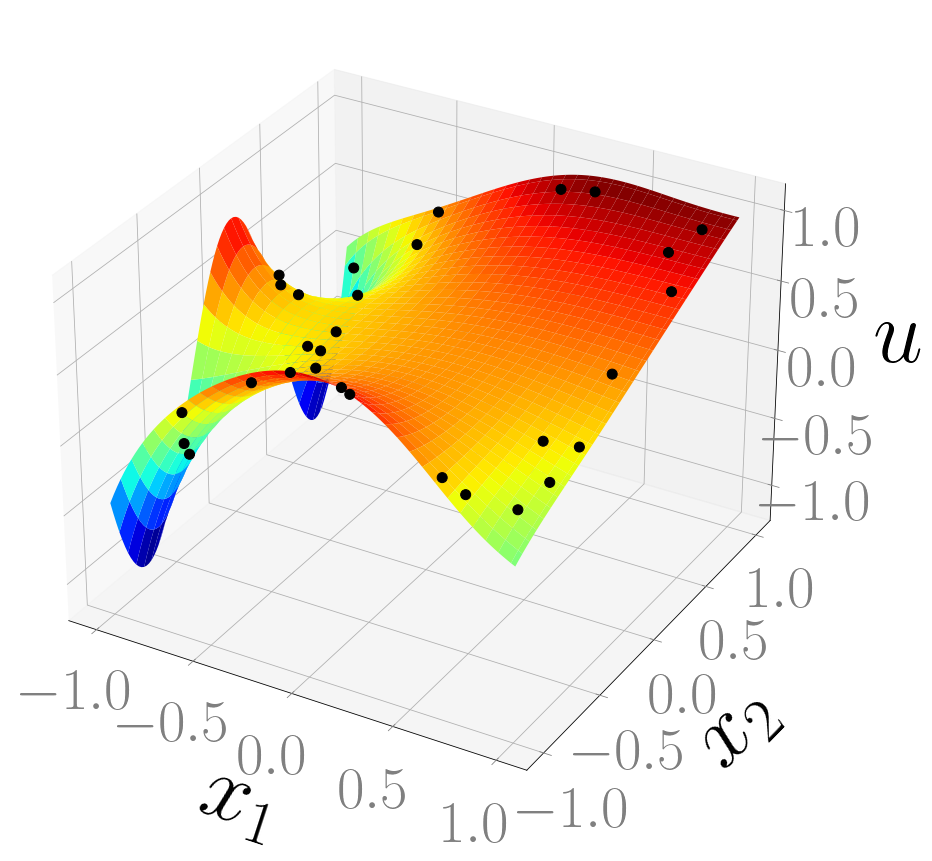

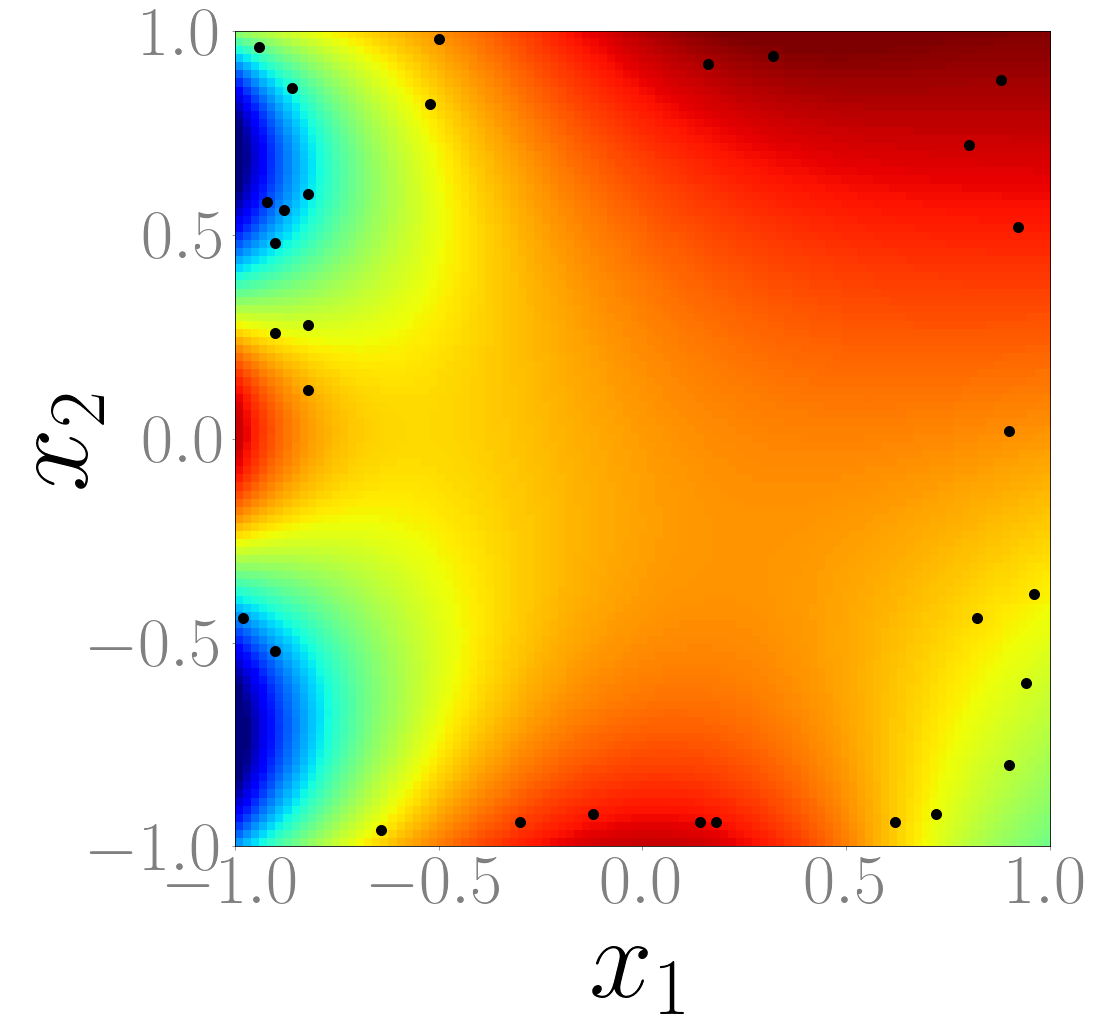

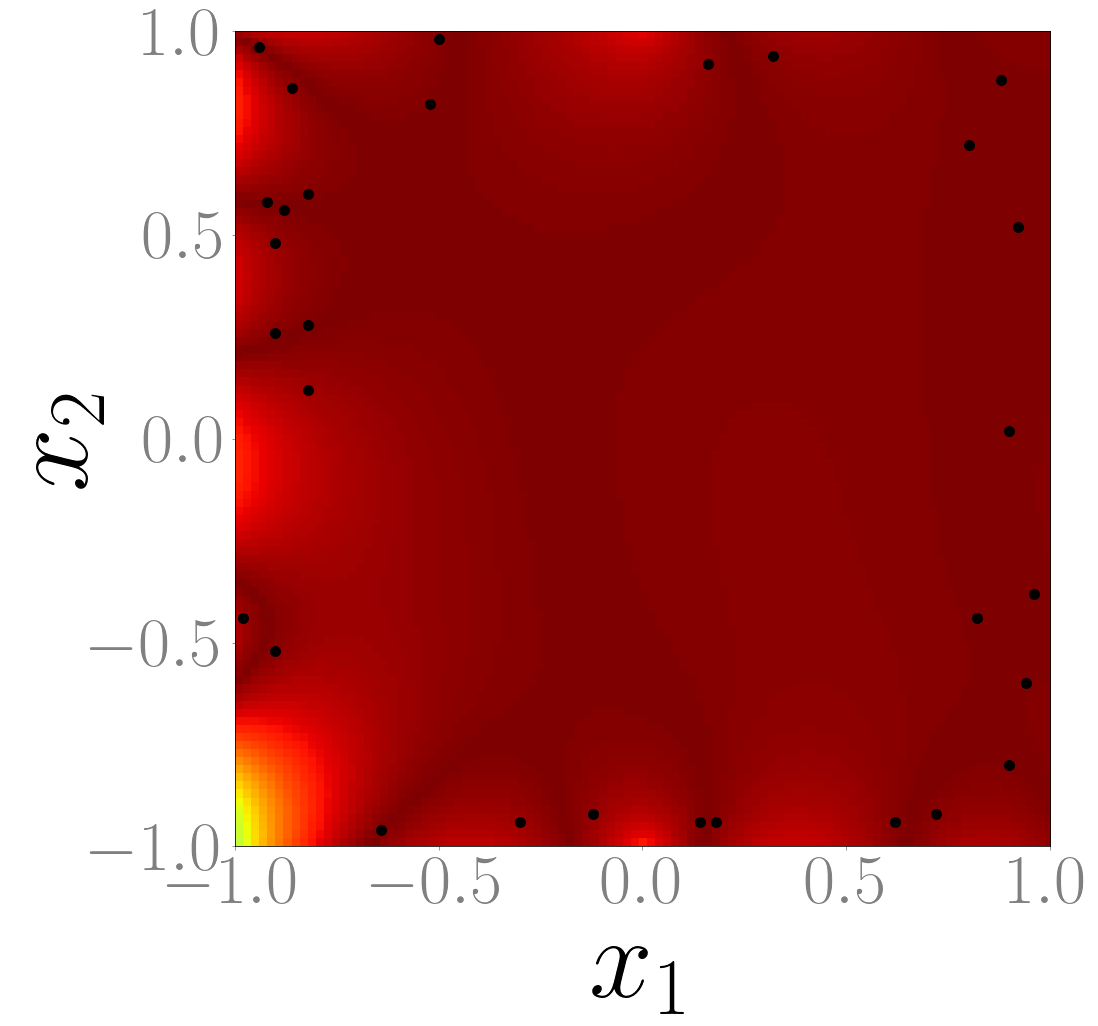

min tensor(2.0862e-06) max tensor(0.4525) mean tensor(0.0168)


In [13]:
# pibi initialisation
lr = 1e-3 # learning rate
pibi, optimiser, scheduler, mse_loss = initialise_pibi(lr)

iterations = 5_001
lambda_physics_data = 1
lambda_physics_coll = 1e-6  # weighting of collocation loss
loss_values, pibi = train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler, mse_loss)

## Visualize convergence of loss function

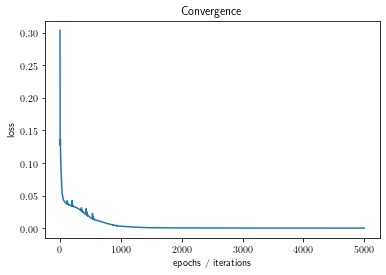

In [14]:
epochs = list(range(1, iterations + 1))
fig, ax = plt.subplots()
ax.plot(epochs, loss_values)
ax.set(xlabel='epochs / iterations',
       ylabel='loss',
       title='Convergence')
# plt.savefig('pibi_loss.jpg', dpi=1000, format='jpeg')
plt.show()